In [5]:
import os
import sys
import random
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Flatten, Dense, Dropout
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

import tensorflow as tf
import tensorflow.contrib.slim as slim

import math

In [2]:
im_width = 128
im_height = 128
im_chan = 1
path_train = 'train'

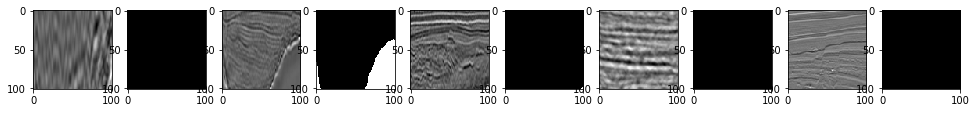

In [3]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img(path_train + '/images/' + img_name + '.png')
    img_mask = load_img(path_train + '/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [4]:
train_ids = next(os.walk(path_train+"/images"))[2]

In [6]:
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 



Done!


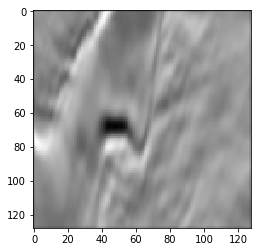

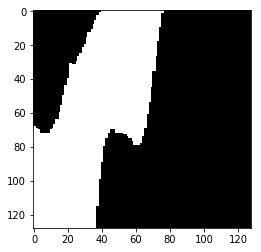

In [12]:
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [13]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [14]:
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou,'acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [ ]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

In [15]:
model.load_weights('model-tgs-salt-1.h5')

## Visualizing layers

In [16]:
def get_featuremaps(model, layer_idx, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()],[model.layers[layer_idx].output,])
    activations = get_activations([X_batch,0])
    return activations

In [37]:
def plot_visualization(activations):
    f, axarr = plt.subplots(2,4)
    axarr[0,0].imshow(activations[0][0,:,:,0],cmap='gray')
    axarr[0,1].imshow(activations[0][0,:,:,1],cmap='gray')
    axarr[0,2].imshow(activations[0][0,:,:,2],cmap='gray')
    axarr[0,3].imshow(activations[0][0,:,:,3],cmap='gray')
    axarr[1,0].imshow(activations[0][0,:,:,4],cmap='gray')
    axarr[1,1].imshow(activations[0][0,:,:,5],cmap='gray')
    axarr[1,2].imshow(activations[0][0,:,:,6],cmap='gray')
    axarr[1,3].imshow(activations[0][0,:,:,7],cmap='gray')
    plt.show()

In [82]:
Y_train[2].shape

(128, 128, 1)

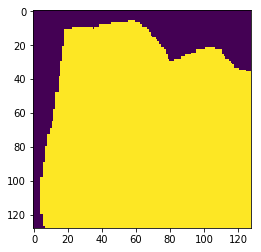

In [87]:
plt.imshow(Y_train[1][:,:,0])

### Layer 1

In [39]:
model.get_layer(index=1).name

'lambda_1'

In [40]:
activations = get_featuremaps(model, 1, X_train[1].reshape(1,128,128,1))

In [41]:
activations[0].shape

(1, 128, 128, 1)

In [42]:
act = activations[0]

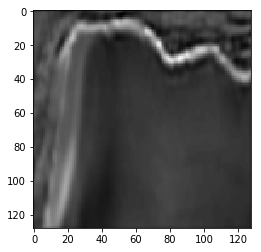

In [43]:
plt.imshow(act[0,:,:,0],cmap='gray')

### Layer 2

In [44]:
model.get_layer(index=2).name

'conv2d_1'

In [45]:
activations = get_featuremaps(model, 2, X_train[1].reshape(1,128,128,1))

In [46]:
activations[0].shape

(1, 128, 128, 8)

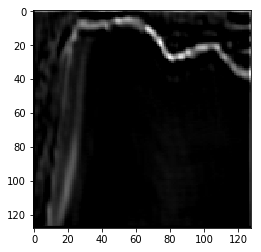

In [47]:
plt.imshow(activations[0][0,:,:,0],cmap='gray')

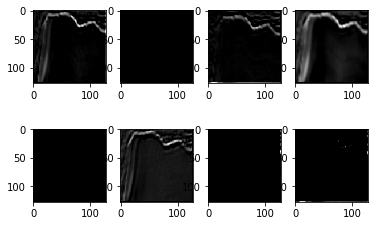

In [48]:
plot_visualization(activations)

### Layer 3

In [49]:
model.get_layer(index=3).name

'conv2d_2'

In [50]:
activations = get_featuremaps(model, 3, X_train[1].reshape(1,128,128,1))

In [51]:
activations[0].shape

(1, 128, 128, 8)

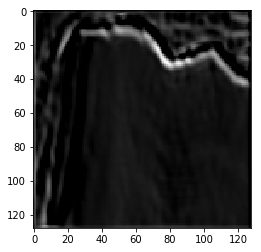

In [52]:
plt.imshow(activations[0][0,:,:,0],cmap='gray')

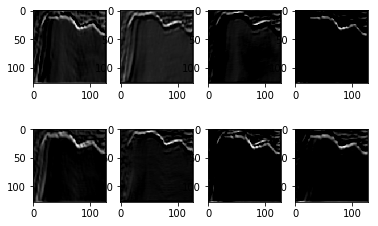

In [53]:
plot_visualization(activations)

### Layer 16

In [54]:
model.get_layer(index=16).name

'conv2d_transpose_1'

In [55]:
activations = get_featuremaps(model, 16, X_train[1].reshape(1,128,128,1))

In [56]:
activations[0].shape

(1, 16, 16, 64)

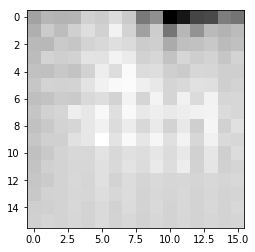

In [57]:
plt.imshow(activations[0][0,:,:,0],cmap='gray')

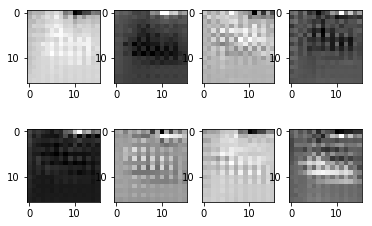

In [58]:
plot_visualization(activations)

### Layer 24

In [59]:
model.get_layer(index=24).name

'conv2d_transpose_3'

In [60]:
activations = get_featuremaps(model, 24, X_train[1].reshape(1,128,128,1))

In [61]:
activations[0].shape

(1, 64, 64, 16)

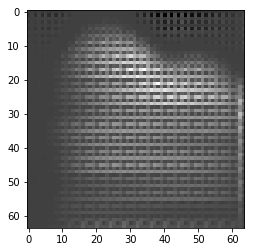

In [62]:
plt.imshow(activations[0][0,:,:,0],cmap='gray')

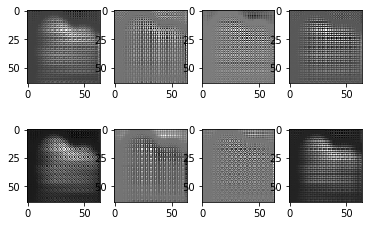

In [63]:
plot_visualization(activations)

### Layer 30

In [67]:
model.get_layer(index=30).name

'conv2d_17'

In [68]:
activations = get_featuremaps(model, 30, X_train[1].reshape(1,128,128,1))

In [69]:
activations[0].shape

(1, 128, 128, 8)

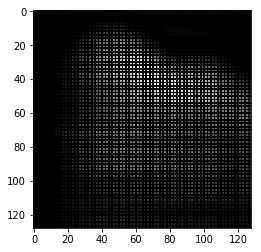

In [70]:
plt.imshow(activations[0][0,:,:,0],cmap='gray')

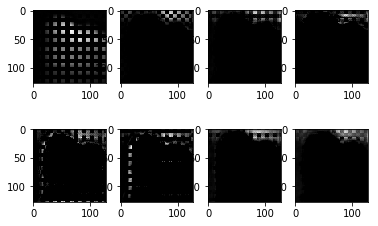

In [71]:
plot_visualization(activations)

### Layer 31

In [72]:
model.get_layer(index=31).name

'conv2d_18'

In [73]:
activations = get_featuremaps(model, 31, X_train[1].reshape(1,128,128,1))

In [74]:
activations[0].shape

(1, 128, 128, 8)

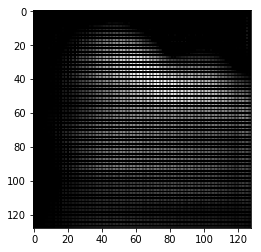

In [75]:
plt.imshow(activations[0][0,:,:,0],cmap='gray')

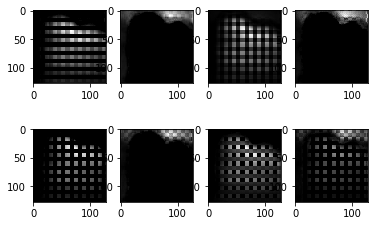

In [76]:
plot_visualization(activations)

### Layer 32

In [77]:
model.get_layer(index=32).name

'conv2d_19'

In [78]:
activations = get_featuremaps(model, 32, X_train[1].reshape(1,128,128,1))

In [79]:
activations[0].shape

(1, 128, 128, 1)

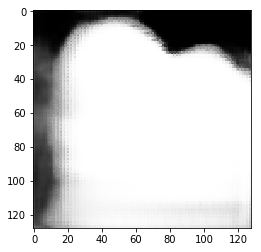

In [80]:
plt.imshow(activations[0][0,:,:,0],cmap='gray')